# NEST SIMULATION     

## 0. LIBRARIES

### 0.1 Regular Libraries

In [1]:
import nest
import matplotlib.pyplot as plt


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-3.1
 Built: Sep 28 2021 11:43:45

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### 0.2 Functions created by me

In [2]:
from getData import *
from plot import *

### 1. IMPORTING DATA

In [3]:
positions_list = getNeuronPositions('net_100')

synaptic_matrix = getSynapses('net_100')

input_matrix = getInput('net_100', 100)

neuron_IDs = getNeuronMatrix('net_100')

## 2. CREATING THE NEST NETWORK

### 2.1 Creating the Neurons

Here we create a position list, with the coordinates of each neuron of the network.
(This first step is not necessary, since the spatial distribution of the network does not influence the NEST simulation.)

In [4]:
pos = nest.spatial.free(positions_list) # using NEURON positions

**All the neurons have the same characteristics. They are all alpha conductance based integrate and fire model, with the default parameters of nest.**

In [5]:
s_nodes = nest.Create("iaf_cond_alpha", 99, positions=pos) 

### 2.2 Connecting the Network

In this version of the simulation **each connected pair has 1 synapses, and all synapses have a weight of -1 x cond x N\***
With the info of the synaptic matrix, we create the pre-synaptic as post-synaptic neuron ID lists, and transform them into numpy arrays

\* N = the # corresponding to their connection on neuron

cond = a value drawn from the conductance distribution used on neuron. (each type of source neuron has a different distribution)

In [6]:
pre_list = []
pos_list = []

for i in range(0,len(synaptic_matrix)):
    pre_list.append(s_nodes[synaptic_matrix[i][0]])
    pos_list.append(s_nodes[synaptic_matrix[i][1]])
    
pre_array = np.transpose(np.array(pre_list)).flatten()
pos_array = np.transpose(np.array(pos_list)).flatten()

With the arrays ready, we can connect the synapses all in one command.
(again here, if we wish to have different parameters and arguments for each synapse, a more complex solution is necessary.)

In [7]:
syn_matrix = old_getWeightedSynapses(pre_array,pos_array)

[[ 1  6  5]
 [ 1 22 24]
 [ 1 31  7]
 ...
 [99 86  2]
 [99 89  4]
 [99 92  3]]


In [8]:
syn_wgt = [] 
conductances = []
for i in range(0,len(syn_matrix)):
    
    neuron_type = neuron_IDs[syn_matrix[i][0]-1][1]
        
    if (neuron_type == 'dspn' or neuron_type == 'ispn' ):
        #"conductance": [2.4e-10, 1e-10]
        cond = np.random.normal(2.4e-10,  1e-10, 1)
        
        if(cond<2.4e-11): #capping at 10% of mean
            cond = 2.4e-11
    elif (neuron_type == 'lts'):
        # conductance mean = 3e-09, std deviation =  0
        cond = 3e-09
        
    elif (neuron_type == 'fs'):
        #"conductance": [1.1e-09, 1.5e-09],
        cond = np.random.normal(1.1e-09, 1.5e-09, 1)
        
        if(cond<1.1e-10): #capping at 10% of mean
            cond = 1.1e-10
    
    conductances.append(cond)    

In [9]:
weights = []
for i in range(0, len(conductances)):
    weights.append(-1*conductances[i]*syn_matrix[i][2])
weights = np.row_stack(weights).flatten()

In [10]:
sources = syn_matrix[:,0]
targets = syn_matrix[:,1]

In [11]:
nest.Connect(sources,targets,conn_spec= "one_to_one", syn_spec= {"weight": weights})

### 2.3 Creating the Input

Now onto the creation of the Spike Generators. **The synapses between the input neurons and the ones on the network all have a weight of 10**

In [12]:
inputs = nest.Create("spike_generator", 99)

In [13]:
for g, generator in enumerate(inputs):
    nest.SetStatus(generator, {"spike_times": input_matrix[g]})

In [14]:
input_syn_wgt = np.full(len(inputs), 15.0)
nest.Connect(inputs,s_nodes, conn_spec= "one_to_one", syn_spec={"weight": input_syn_wgt})

### 2.4 Creating the Recording Devices

In [15]:
spikerecorder = nest.Create("spike_recorder")

In [16]:
nest.Connect(s_nodes,spikerecorder, conn_spec= "all_to_all")

In [17]:
multimeter = nest.Create("multimeter")
multimeter.set(record_from=["V_m"])
nest.Connect(multimeter,s_nodes, "all_to_all")

In [18]:
mult1 = nest.Create("multimeter", 5)
mult1.set(record_from=["V_m"])
chosen_nodes = [1,11,21,31,41]
nest.Connect(mult1,chosen_nodes, "one_to_one")

## 3. RUNNING THE SIMULATION
Here we are using a total run itme of 2000 ms (and the default step of simulation of 0.1 ms)

In [19]:
nest.Simulate(2000.0)


Nov 18 15:26:35 NodeManager::prepare_nodes [Info]: 
    Preparing 205 nodes for simulation.

Nov 18 15:26:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 205
    Simulation time (ms): 2000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Nov 18 15:26:36 SimulationManager::run [Info]: 
    Simulation finished.


## 4. ANALYSING THE RESULTS

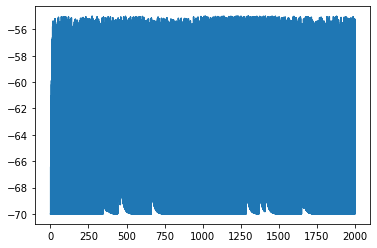

In [20]:
dmm = multimeter.get()
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
ids = dmm["events"]["senders"]

plt.figure(1)
plt.plot(ts, Vms)
plt.show()

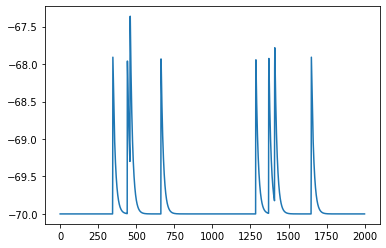

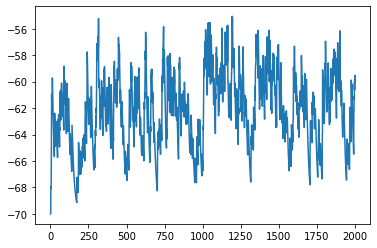

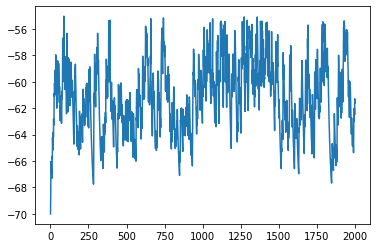

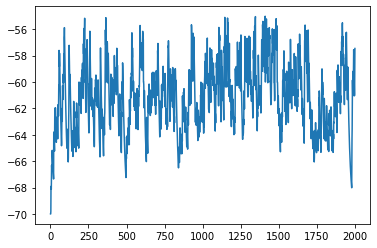

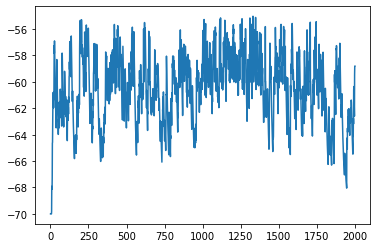

In [21]:
for i in range(0,5):
    dmm1 = mult1[i].get()
    Vms1 = dmm1["events"]["V_m"]
    ts1 = dmm1["events"]["times"]
    ids1 = dmm1["events"]["senders"]

    plt.figure(1)
    plt.plot(ts1, Vms1)
    plt.show()

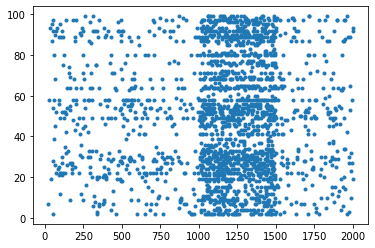

In [22]:
dSD = spikerecorder.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.figure(2)
plt.plot(ts, evs, ".")
plt.show()

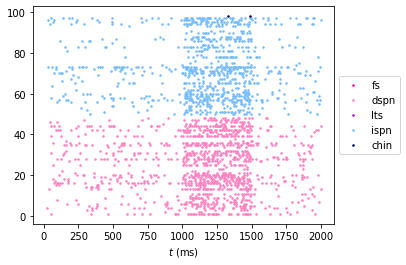

In [23]:
spikes = {}

for i in range(0, len(evs)) :

    nID = evs[i]
    spike_time = ts[i]
    if(nID not in spikes.keys()):
        spikes[nID] = []            
    spikes[nID].append(spike_time)

for i in range(0, 100):
    if(i not in spikes.keys()):
        spikes[i] = []

chin_color='xkcd:dark blue'
ispn_color='xkcd:sky blue'
lts_color='xkcd:violet'
dspn_color='xkcd:pink'
fs_color='xkcd:hot pink'

n_ids = np.array(list(spikes.keys()), dtype=int)
n_ids.sort() #organize the neurons by id

dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_IDs)

orderedIDs = getOrderedIDs(dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID)


fig_handle = plt.figure()
ax = fig_handle.add_subplot(111)
ax.set_xlabel('$t$ (ms)')

plotSpikes(spikes, fs_ID, orderedIDs, fs_color, 'fs', ax)
plotSpikes(spikes, dspn_ID, orderedIDs,dspn_color, 'dspn', ax)
plotSpikes(spikes, lts_ID, orderedIDs, lts_color, 'lts', ax)
plotSpikes(spikes, ispn_ID, orderedIDs,ispn_color , 'ispn', ax)
plotSpikes(spikes, chin_ID, orderedIDs, chin_color, 'chin', ax)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
# Put a legend to the right of the current axis

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [24]:
for neuron_dspn in dspn_ID:
    spikes_aux = events[neuron_dspn] #array of the spike times of neuron i
    dspn_spks.append(spikes_aux)

NameError: name 'events' is not defined

In [ ]:
for neuron_dspn in dspn_ID:
    spikes_aux = events[neuron_dspn] #array of the spike times of neuron i
    dspn_spks.append(spikes_aux)
    
    ispn_spks = []
    lts_spks = []
    chin_spks = []
    fs_spks = []

    with open(file_path, 'r') as file:
        lines = file.readlines()

    spikes = {}

    for line in lines :

        split_line = np.array(line.split("\t"),float)
        nID = int(split_line[1])
        spike_time = split_line[0]

        if neuron_IDs[nID][1] == 'dspn':
            dspn_spks.append(spike_time)

        elif neuron_IDs[nID][1] == 'ispn':
            ispn_spks.append(spike_time)

        elif neuron_IDs[nID][1] == 'fs':
            fs_spks.append(spike_time)

        elif neuron_IDs[nID][1] == 'chin':
            chin_spks.append(spike_time)

        elif neuron_IDs[nID][1] == 'lts':
            lts_spks.append(spike_time)

    dspn_spikes_dt = []
    ispn_spikes_dt = []
    chin_spikes_dt = []
    lts_spikes_dt = []
    fs_spikes_dt = []

    for d_time in range (0, 1991, 10):

        start = d_time
        stop = d_time + 10
        spikes_dt_aux = [0,0,0,0,0]

        for elem in dspn_spks:
            if (start < elem <= stop):
                spikes_dt_aux[0] +=1
        for elem in ispn_spks:
            if (start < elem <= stop):
                spikes_dt_aux[1] +=1
        for elem in chin_spks:
            if (start < elem <= stop):
                spikes_dt_aux[2] +=1
        for elem in lts_spks:
            if (start < elem <= stop):
                spikes_dt_aux[3] +=1
        for elem in fs_spks:
            if (start < elem <= stop):
                spikes_dt_aux[4] +=1

        dspn_spikes_dt.append(spikes_dt_aux[0])
        ispn_spikes_dt.append(spikes_dt_aux[1])
        chin_spikes_dt.append(spikes_dt_aux[2])
        lts_spikes_dt.append(spikes_dt_aux[3])
        fs_spikes_dt.append(spikes_dt_aux[4])

    dspn, ispn, lts, fs, chin = getNeuronSubMatrixes(neuron_IDs)
    N_dspn = len(dspn)
    N_ispn = len(ispn)
    N_chin = len(chin)
    N_lts= len(lts)
    N_fs = len(fs)

    dspn_fr = []
    ispn_fr = []
    chin_fr = []
    lts_fr = []
    fs_fr = []

    for elem in dspn_spikes_dt:
        dspn_fr.append(elem*100/(N_dspn))
    for elem in ispn_spikes_dt:
        ispn_fr.append(elem*100/(N_ispn))
    for elem in chin_spikes_dt:
        chin_fr.append(elem*100/(N_chin))
    for elem in lts_spikes_dt:
        lts_fr.append(elem*100/(N_lts))
    for elem in fs_spikes_dt:
        fs_fr.append(elem*100/(N_fs))

    time = []
    for d_time in range (0, 1991, 10):
        time.append(d_time)

### OTHERS

In [ ]:
def plotRaster(folder_path, size):
    ''' Given a path to a folder inside NEURON-data, generates the raster plot for the corresponding simulation
        (folder_path is "NEURON-data/net_X" )
    '''    
    spikes_dict = getSpikes(folder_path, size)
    
    n_ids = np.array(list(spikes_dict.keys()), dtype=int)
    n_ids.sort() #organize the neurons by id

    neuron_matrix = getNeuronMatrix(folder_path)
    dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID = getNeuronSubMatrixes(neuron_matrix)
    
    orderedIDs = getOrderedIDs(dspn_ID, ispn_ID, lts_ID, fs_ID, chin_ID)


    fig_handle = plt.figure()
    ax = fig_handle.add_subplot(111)
    ax.set_xlabel('$t$ (ms)')

    plotSpikes(spikes_dict, fs_ID, orderedIDs, fs_color, 'fs', ax)
    plotSpikes(spikes_dict, dspn_ID, orderedIDs,dspn_color, 'dspn', ax)
    plotSpikes(spikes_dict, lts_ID, orderedIDs, lts_color, 'lts', ax)
    plotSpikes(spikes_dict, ispn_ID, orderedIDs,ispn_color , 'ispn', ax)
    plotSpikes(spikes_dict, chin_ID, orderedIDs, chin_color, 'chin', ax)


    plt.legend()
    plt.show()
